In [3]:
import radvel
import numpy as np
import rebound as rb
import reboundx
import matplotlib.pyplot as plt
import celmech as cm
import pandas as pd
import h5py
from tqdm import tqdm

Set up model using $K_1$, $\frac{m_2}{m_1}$, $e_1$, $\omega_1$, $\dot{\omega}$, $P_1$, $\lambda_1$ or $M_1$:

In [4]:
hd_data = pd.read_csv('hd45364_rvs.csv', sep = ';')
hd_data.BJD -= 2.4e6

cluster_data = h5py.File('hd_mcmc_cluster.h5', 'r')  # import the posterior distribution data from the cluster
accepted, samples, log_prob = np.array(cluster_data['mcmc']['accepted']), np.array(cluster_data['mcmc']['chain']), np.array(cluster_data['mcmc']['log_prob'])

n_burn_in = 200  # discard the first 200 samples as burn-in time
# reshape the chain to flatten it out
flat_samples = samples[n_burn_in:].reshape(-1, samples[n_burn_in:].shape[-1])

Model -- use RV model in equilibrium. First find the constant $c$ in $\frac{e_1}{e_2} = c \times \frac{m_2}{m_1}$, using the `REBOUNDx` eccentricity track simulations:

In [5]:
nsims = 100
Ks_orig = np.logspace(0, 5, nsims)
ecc_sims_location = 'hd_max_mass'
# initialize c array
cs = np.zeros(len(Ks_orig))

for i in range(0, len(Ks_orig)):
    ecc_sim = rb.Simulation(f'{ecc_sims_location}/ecc_track_archive_cluster_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    inner = ecc_sim.particles[1]
    outer = ecc_sim.particles[2]
    # print(inner.m, outer.m)
    cs[i] = (inner.e * inner.m)/(outer.e * outer.m)  # compute c by rearranging

In [6]:
np.median(cs)

0.9067963293569362

(array([ 1.,  4.,  2.,  3.,  2.,  3., 10., 29., 31., 15.]),
 array([0.19111961, 0.28128896, 0.37145831, 0.46162766, 0.55179701,
        0.64196636, 0.73213571, 0.82230506, 0.91247441, 1.00264376,
        1.09281311]),
 <BarContainer object of 10 artists>)

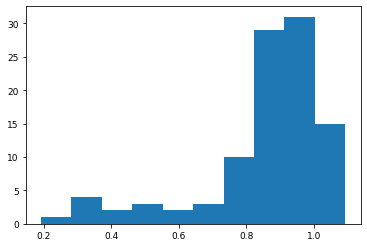

In [7]:
plt.hist(cs)

Create rv

In [8]:
#Least squares fit: 
fit_params = [ 2.28513053e+02, 7.27743508e+00, 5.39371890e+04, -1.78110513e-01, 
              -4.66450116e-02, 3.43378023e+02, 1.78603199e+01, 5.40186750e+04,
               1.32165040e-01, 9.73129308e-02, -5.29039776e-01] 

# star mass, g and auday to m/s conversion factor
STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor to convert from au/day --> m/s

def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude (in au/day)
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude (in au/day) to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, inclination, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is jit
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = int((len(params) - 1) / 5) # -2 because there are rv_offset and jit parameters:
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')

    sim.add(m = star_mass)  # star mass as a constant
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 4], params[5*i + 3])  # omega from arctan of sesin, secos  (in that order!)
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim

def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim


def get_rvs(params, inclination, times, integrator, time_base, auday_ms = AUDAY_MS):
    
    """
    Gets RVs from a Numpy array of planet params
    
    param params:     for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param times: array of times to integrate over
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    
    """
    
    sim = get_sim_from_params(params, inclination, integrator, time_base = time_base)
    
    sim_backwards = sim.copy()
    sim_backwards.dt *= -1  # set timestep to be negative if integrating backwards
    
    forward_times = np.array(list(filter(lambda x: x - time_base >= 0, times)))
    backward_times = np.array(list(filter(lambda x: x - time_base < 0, times)))
    
    # initialize rvs
    rv_forward = np.zeros(len(forward_times))
    rv_backward = np.zeros(len(backward_times))
    
    num_planets = int((len(params) - 1) / 5)  # find number of planets in params passed
    
    # get the rvs (z velocity, assuming 90 deg inclination) from the rebound simulation to compare with the actual simulation
    for i, t in enumerate(forward_times):
        sim.integrate(t, exact_finish_time = 1)
        # integrate to the specified time, exact_finish_time = 1 for ias15, 
        # sim.status()
        star = sim.particles[0]
        rv_forward[i] = (-star.vz * auday_ms) + params[5 * num_planets]  # use x-velocity of the star as the radial velocity, convert to m/s
    
    for i, t in enumerate(backward_times):
        sim_backwards.integrate(t, exact_finish_time = 1)
        star = sim_backwards.particles[0]
        rv_backward[i] = (-star.vz * auday_ms) + params[5 * num_planets]
    
    return np.concatenate((rv_backward, rv_forward))

Parameters ($K_1, \frac{m_2}{m_1}, e_1, \omega_1, \dot\omega, P_1, \lambda_1$ or $M_1$):

In [9]:
test_samp = flat_samples[2000]

In [10]:
# test parameters
time_base = np.median(hd_data.BJD)
fit_sim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator = 'ias15', time_base = time_base)
# 7 parameters
k1 = test_samp[1]# /AUDAY_MS  # k1
e1 = test_samp[3] ** 2 + test_samp[4] ** 2  # e1
p1 = test_samp[0]  # p1
Tprecess = 50 * p1
m2_m1 = fit_sim.particles[2].m/fit_sim.particles[1].m
omega1 = np.arctan2(test_samp[3], test_samp[4])
# use from the precessingrvsignal notebook
omegadot = 2 * np.pi /Tprecess  # omegadot = omegadot1 = omegadot2
tp1 = radvel.orbit.timetrans_to_timeperi(test_samp[2], per = p1, ecc = e1, omega = omega1)
# and the constant c, using the median as the constant
c = 1.07

# compute tihngs needed

# compute m1 from K1 and e1 using semiamp_to_mass
m1 = semiamp_to_mass(semiamp = k1/AUDAY_MS, star_mass = STAR_MASS, period = p1, eccentricity = e1, inclination = np.pi/2)
# compute m2 using m1 and m2/m1 as a parameter
m2 = m2_m1 * m1
# compute e2 using e1, m1, m2
e2 = (e1 * m1)/(c * m2)
# compute p2 usng omegadot, since thetadot1 = thetadot2 = 0
p2 = (3 * np.pi * p1)/(2 * np.pi + p1 * omegadot)  # rearrange the equation
# compute K2 using m2, e2, and p2
k2 = mass_to_semiamp(planet_mass = m2, star_mass = STAR_MASS, period = p2, eccentricity = e2, inclination=np.pi/2) * AUDAY_MS
# compute omega2 as omega1 + pi
omega2 = omega1 + np.pi
# compute mean anomalies M1, M2



# TODO:
# convert tp to lambda, and compute lambda1 and lambda2
# also compute theta1 and 2 as well (note that theta1 = theta2 + (either 0 or pi))

In [11]:
tp1, radvel.orbit.timetrans_to_timeperi(test_samp[7], per = p2, ecc = e2, omega = omega2)  # tp1 and tp2 values

(53827.057742615485, 54024.829734942985)

In [12]:
def get_mean_anomaly(t, period, tp):
    """
    Gets mean anomaly at a specified time t, given the period P of the planet and the time of pericenter passage tp
    
    Mean anomaly is in radians
    """
    return ((2 * np.pi)/period) * (t - tp)
    

Compare fit params and this:

In [13]:
fit_params  # p1, k1, tc1, sqrt(e1) * cos(omega1), sqrt(e1) * sin(omega1) and same for 2, plus rv offset at the end

[228.513053, 7.27743508, 53937.189, -0.178110513, -0.0466450116, 343.378023, 1
7.8603199, 54018.675, 0.13216504, 0.0973129308, -0.529039776]

In [14]:
p1, k1, e1, m1, p2, k2, e2, m2

(228.57044652960857, 7.305026710113224, 0.023988316851047867, 0.20152652656450
432, 336.1330096023656, 18.056644027326843, 0.007973687736480968, 0.5666162096
957676)

In [15]:
# ?get_sim_from_params

In [16]:

# radvel.kepler.rv_drive(p1, )

In [17]:
import sympy as sp

l1, l2, omegai = sp.symbols('lambda1, lambda2, omega_i')
thetai = sp.symbols('theta_i')
M1, M2, p1, p2, t, Tp1, Tp2 = sp.symbols('M1, M2, p1, p2, t, Tp1, Tp2')
omega1, omega2 = sp.symbols('omega1, omega2')

n = 0

# resonant angle equation
thetai = 3 * l2 - 2 * l1 - omegai
# rearranging Mi = lambdai - omegai and substituting in
thetai = thetai.subs([(l1, M1 + omega1), (l2, M2 + omega2 - n * (2/3 * np.pi))])
# then substitute M = 2pi/P (t - Tp) for both
thetai = thetai.subs([(M1, (2 * np.pi)/p1 * (time_base - Tp1)), (M2, (2 * np.pi)/p2 * (time_base - Tp2))])
# substitute t = 0 since it doesn't matter, and then omegai = omega2 here, and omega1 = omega2 + pi) 
thetai = thetai.subs([(t, 0), (omegai, omega2), (omega1, omega2 + np.pi)])
# finally solve for Tp2 in terms of Tp1, p1 and p2:
tp2_expr = sp.solve(thetai, Tp2)[0]

In [18]:
tp2_expr, tp2_expr.subs([(p1, test_samp[0]), (p2, test_samp[5]), (Tp1, 53827)])  # tp2 should be 54024

⎛4.24413181578387e-24⋅(1.5707963267949e+23⋅Tp₁⋅p₂ + p₁⋅(1.2830127289518e+28 - 
⎜─────────────────────────────────────────────────────────────────────────────
⎝                                                              p₁             

7.85398163397449e+22⋅p₂) - 8.553418193012e+27⋅p₂)                  ⎞
─────────────────────────────────────────────────, 53711.7920324578⎟
                                                                   ⎠

In [19]:
0 - (2 * test_samp[5])/(3 * test_samp[0]) * (0 - 53827)

53894.11634619993

In [20]:
test_samp

array([ 2.28570447e+02,  7.30502671e+00,  5.39365326e+04, -1.53652046e-01,
        1.94773112e-02,  3.43283173e+02,  1.78184523e+01,  5.40181909e+04,
        1.43601538e-01,  1.11396398e-01, -6.68446640e-01])

Need $P_1, T_{p1}, e_1, \omega_1, K_1$ explicitly, and implement $\dot\omega$ in the same way in the precessing rv signal notebook ($12$ parameters) to build the `radvel.kepler.rv_drive()` forward model

Write a function that returns an RV signal for a given set of 7 parameters assuming equilibrium:

In [21]:
time_base = np.median(hd_data.BJD)

In [393]:
def get_rv_signal_equilibrium(times, params, c, time_base):
    """
    Gets an RV signal under the equilibrium constraints using the radvel.kepler.rv_drive() function
    for a set of 7 equilibrium parameters as well as the constant c in the equation e1/e2 = c * m2/m1,
    and the base time time_base
    
    Params are in the order K1, m2/m1, e1, omega1, omegadot, P1, Tp1, rv_offset
    
    k1: semi-amplitude of the inner planet, in m/s
    m2/m1: ratio of outer planet to inner planet's mass, dimensionless
    e1: eccentricity of inner planet, dimensionless
    omega1: argument of pericenter of inner planet, radians
    omegadot: rate of precession (omegadot = omegadot_1 = omegadot_2), UNITS
    p1: period of inner planet, days
    tp1: time of pericenter passage of inner planet, days
    rv_offset: rv offset of star, in m/s
    
    return tuple of keplerian and rebound rvs, both generated using the set of parameters passed, and the rebound params used
    to generate the simulation
    
    kep_rvs: keplerian forward model (using radvel.kepler.rv_drive() function) rvs, m/s
    rb_rvs: rebound rvs, m/s
    rb_params: parameters used to generate the rebound simulation (for the rvs)
    [p1, k1, tc1, secos1, sesin1, p2, k2, tc2, secos2, sesin2, rv_offset]
    """
    k1, m2m1, e1, omega1, omegadot, p1, tp1, rv_offset = params  # params are in this order
    # compute m1 from K1 and e1 using semiamp_to_mass
    # divide the semi amplitude by auday_ms since it is given in m/s and semiamp_to_mass takes it in au/day
    m1 = semiamp_to_mass(semiamp = k1/AUDAY_MS, star_mass = STAR_MASS, period = p1, eccentricity = e1, inclination = np.pi/2)
    # compute m2 using m1 and m2/m1 as a parameter
    m2 = m2m1 * m1
    # compute e2 using e1, m1, m2 and the constant c
    e2 = (e1 * m1)/(c * m2)
    # compute p2 usng omegadot, since thetadot1 = thetadot2 = 0
    p2 = (3 * np.pi * p1)/(2 * np.pi + p1 * omegadot)  # rearrange the equation
    # compute K2 using m2, e2, and p2
    # multiply the resulting semi amplitude by auday_ms to get into m/s since mass_to_semiamp returns it in au/day
    k2 = mass_to_semiamp(planet_mass = m2, star_mass = STAR_MASS, period = p2, eccentricity = e2, inclination=np.pi/2) * AUDAY_MS
    # compute omega2 as omega1 + pi
    omega2 = omega1 + np.pi
    # finally compute Tp2
    tp2 = time_base - p2/2 - (2/3) * (p2/p1) * (time_base - tp1)
    # then put these into the radvel.kepler.rv_drive() function:
    # p1, tp1, e1, omega1, k1, plus omegadot implemented using list comprehension and adding t * omegadot to omega1
    inner_signal = np.array([radvel.kepler.rv_drive(np.array([t]), [p1, tp1, e1, omega1 + (t - time_base) * omegadot, k1]) for t in times]).reshape(-1)
    # same for outer
    outer_signal = np.array([radvel.kepler.rv_drive(np.array([t]), [p2, tp2, e2, omega2 + (t - time_base) * omegadot, k2]) for t in times]).reshape(-1)
    # return the sum of the two signals (since it's keplerian), plus the constant rv offset
    kep_rvs = inner_signal + outer_signal + rv_offset
    # now generate rvs from rebound using these parameters and a couple others
    # time of conjunction
    tc1 = radvel.orbit.timeperi_to_timetrans(tp1, p1, e1, omega1)
    tc2 = radvel.orbit.timeperi_to_timetrans(tp2, p2, e2, omega2)
    # sesin and secos
    secos1, sesin1 = np.sqrt(e1) * np.array([np.cos(omega1), np.sin(omega1)])
    secos2, sesin2 = np.sqrt(e2) * np.array([np.cos(omega2), np.sin(omega2)])
    # rebound parameters
    rb_params = [p1, k1, tc1, secos1, sesin1, p2, k2, tc2, secos2, sesin2, rv_offset]
    # get rvs using this
    rb_rvs = get_rvs(rb_params, inclination = np.pi/2, times = times, integrator = 'whfast', time_base = time_base)
    # return keplerian rvs, rebound rvs and the parameters used to generate the simulation as a 3-tuple
    return kep_rvs, rb_rvs, rb_params
    

Use parameters from the best-fit value from the least-squares (or posterior):

In [394]:
fit_params

[228.513053, 7.27743508, 53937.189, -0.178110513, -0.0466450116, 343.378023, 1
7.8603199, 54018.675, 0.13216504, 0.0973129308, -0.529039776]

Also use these params to find the resonant libration angles:

In [395]:
sim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator = 'ias15', time_base = time_base)
# inner, outer planets
sim_inner = sim.particles[1]
sim_outer = sim.particles[2]
# generate tiem array
# times = np.linspace(time_base, time_base + sim_inner.P * 50, int(1e4))  # 50 orbital periods
# use c from earlier, use time_base time_base, and use the parameters determined from sim:
k1 = mass_to_semiamp(sim_inner.m, star_mass=STAR_MASS, period=sim_inner.P, eccentricity=sim_inner.e, inclination=np.pi/2) * AUDAY_MS  # semiamplitude for first
m2m1 = sim_outer.m/sim_inner.m  # ratio of m2 to m1
e1 = sim_inner.e  # eccentricity
omega1 = sim_inner.omega  # omega
omegadot = 0  # 2 * np.pi/(50 * sim_inner.P)  # just use 0 at first and then change this slowly i guess, should be very small
p1 = sim_inner.P   # period
tp1 = sim_inner.T  # time of pericenter passage
rv_offset = fit_params[-1]

# all seven parameters together:
eq_model_params = [k1, m2m1, e1, omega1, omegadot, p1, tp1, rv_offset]
eq_model_params, c

([7.277435079999999, 2.811620977918289, 0.03389911194828719, 3.397728379422484
4, 0, 228.51305300000024, 72.15181979370496, -0.529039776], 1.07)

Generate RV signal from equilibrium forward model, compare to a `REBOUND`-generated one:

In [396]:
times = np.linspace(time_base, time_base + fit_params[0] * 10, int(1e4))  # 10 times the inner planet's orbital period
# equilibrum forward model and rebound rv model using c and time_base
eq_rv_signal, rb_rv_signal, rb_params = get_rv_signal_equilibrium(times, eq_model_params, c, time_base)
# rb_rv_signal = get_rvs(fit_params, np.pi/2, times, integrator='ias15', time_base = time_base)

eq_rv_signal, rb_rv_signal

(array([-7.97083254, -8.07848526, -8.18604875, ..., 18.94251957,
        18.90172066, 18.86051824]),
 array([-7.96595512, -8.07355124, -8.18105825, ..., 18.15894983,
        18.11215768, 18.0649685 ]))

Plot resonant angles using `rb_params`:

In [397]:
rb_params

[228.51305300000024, 7.277435079999999, 8.108491999989425, -0.1781105130000001
4, -0.04664501159999814, 342.76957950000036, 17.865530756757177, -28.700414829
51781, 0.10268790134536115, 0.026892732319702146, -0.529039776]

In [398]:
times = np.linspace(time_base, time_base + fit_params[0] * 100, int(1e4))

theta1, theta2 = np.zeros(len(times)), np.zeros(len(times))
sim = get_sim_from_params(rb_params, np.pi/2, 'ias15', time_base)
inner = sim.particles[1]
outer = sim.particles[2]
# get the resonant angles 
for i, t in enumerate(times):
     # integrate
    sim.integrate(t)
    # resonant angle
    resonant_angle = 3 * outer.l - 2 * inner.l
    # theta1 and 2 since theta1 and 2 are both 3lambda_2 - 2lambda_1 - pomega_1/2
    theta1[i] = np.mod(resonant_angle - inner.pomega, 2 * np.pi)
    theta2[i] = np.mod(resonant_angle - outer.pomega, 2 * np.pi)

Plto:

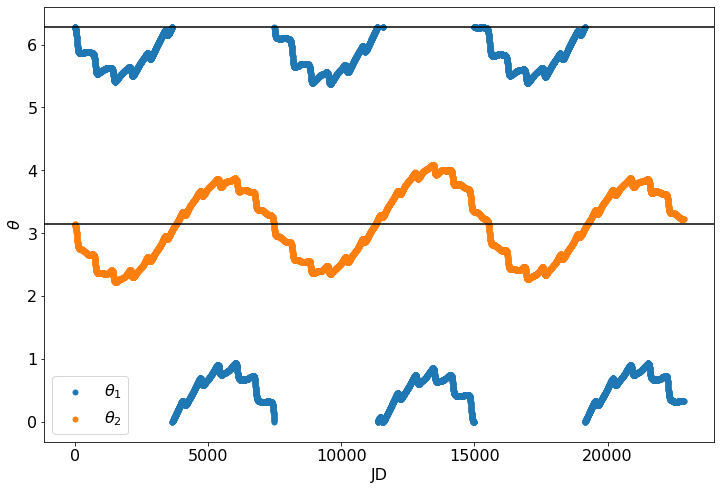

In [399]:
plt.figure(figsize = (12, 8))
plt.rc('font', size = 16)
plt.scatter(times, theta1, label = r'$\theta_1$')
plt.scatter(times, theta2, label = r'$\theta_2$')
plt.axhline(y=2*np.pi, color='k')
plt.axhline(y=np.pi, color='k')
plt.xlabel('JD'), plt.ylabel(r'$\theta$')
plt.legend()

Also plot RV signals to compare:

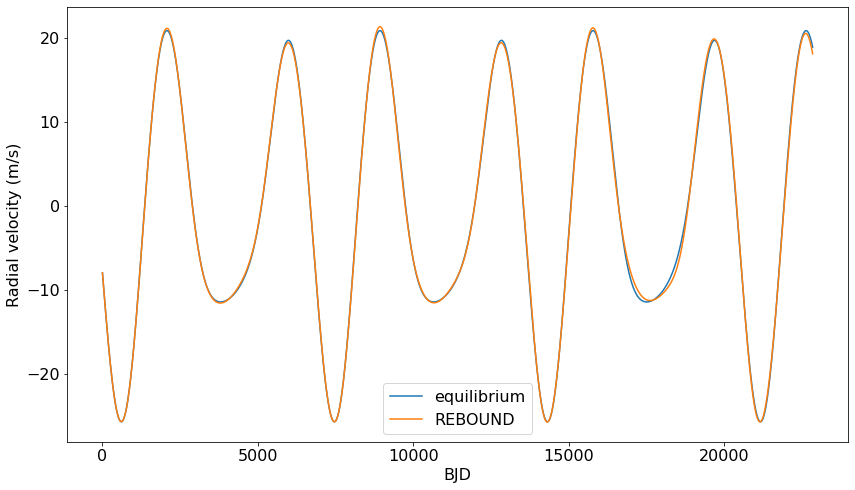

In [400]:
plt.figure(figsize = (14, 8))
plt.rc('font', size = 16)
# Keplerian RV signal generated by the equilibrium forward model
plt.plot(times, eq_rv_signal, label = 'equilibrium')
# n-body RV signal generated by REBOUND
plt.plot(times, rb_rv_signal, label = 'REBOUND')
# label
plt.xlabel('BJD'), plt.ylabel('Radial velocity (m/s)')
plt.legend()
plt.show()

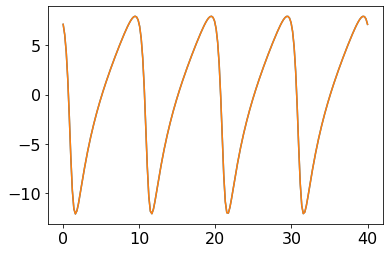

In [401]:
period = 10
tp =1
e = 0.5
om = 2
K = 10
times = np.linspace(0,40,200)
Tprecess = 50 * period
# omegadot = 2 * np.pi /Tprecess

rv_signal = radvel.kepler.rv_drive(times,[period,tp,e,om,K])

secos, sesin = np.sqrt(e) * np.cos(om), np.sqrt(e) * np.sin(om)
test_pars = [period, K, radvel.orbit.timeperi_to_timetrans(tp, period, e, om), secos, sesin, 0]

plt.plot(times,rv_signal)
plt.plot(times, get_rvs(test_pars, inclination=np.pi/2, times=times, integrator='ias15', time_base=0))

In [402]:
tp, radvel.orbit.timetrans_to_timeperi(radvel.orbit.timeperi_to_timetrans(tp, period, e, om), period, e, om)

(1, 1.0)

Grab equilibrium track simualations. Then make an RV signal using REBOUND, and fit the RV signal with the analytic model using `scipy.optimize.least_squares()` etc.

In [403]:
time_base = 0

Take the simulation corresponding to $K \approx 90$, since the posterior distribution before shows it's about that value:

In [404]:
index = np.abs(Ks_orig - 90).argmin()  # index of the Ks_original closest to K = 90
Ks_orig[index]

93.26033468832199

Units of simulation are distance  mass `Mstar`, time `inner.P`

In [405]:
ecc_sims_location = 'hd_max_mass'  # location of simulations
# get the simulation
Ks_sim = rb.Simulation(f'{ecc_sims_location}/ecc_track_archive_cluster_{index}.bin')  # get the corresponding eccentricity simulation
Ks_sim.t = 0
# define star, inner, outer planets
star = Ks_sim.particles[0]
inner = Ks_sim.particles[1]
outer = Ks_sim.particles[2]
# since it's already at equilibrium, then make an RV signal with REBOUND over a few orbital periods
# Ks_sim.t = time_base
Ks_sim_time_base = Ks_sim.t
# 10 times the orbital period of the inner planet
# move to center of mass and then align it so z-axis is movement

Currently have $v = \left(\frac{P_1^2\,G\,M}{4\pi^2}\right)^{1/3}\,\frac{1}{P_1} = \left(\frac{G\,M}{4\pi^2 P}\right)^{1/3}$, and $v = \frac{1}{\left(2\pi\right)^{2/3}} \approx 0.293$ when using units of $G = 1$, $M_\star = 1$, $P_1 = 1$. Converting to units of $G$ in $AU^3\,M_{jup}^{-1}\,days^{-2}$, $M_\star$ in $M_{jup}$, and $P$ in $days$ we have a conversion factor of:

In [406]:
inner.a, 1/(4 * np.pi ** 2) ** (1/3)

(0.2920488534835459, 0.2936838654966136)

In [407]:
G = 2.825e-7  # conversion factor for G in terms of au^3/(jupiter masses * days^2)
STAR_MASS = 920  # conversion factor for M from M* to Mjup
P1 = fit_params[0]  # conversion factor for M from inner planet periods to days

In [408]:
v_natural = ((G * STAR_MASS)/(4 * np.pi ** 2 * P1)) ** (1/3)/inner.a  # then divide by inner.a to normalize
v_natural  # now v in terms of AU/day

0.010496785866859634

Now convert $v$ from au/day to m/s:

In [409]:
v_conv = v_natural * AUDAY_MS
v_conv, AUDAY_MS

(18169.93633553403, 1731000.0)

Integrate after first rotating the system so that the star's radial velocity is aligned along the $z$-axis:

In [410]:
r = np.matrix([[1, 0, 0],
              [0, 0, 1],
              [0, 1, 0]])  # np.pi/2 rotation matrix so everything is aligned along z

# implement rotation for particles 0, 1, and 2 in the simulation

def rotate_sim(sim, rot_matrix):
    """
    Rotates all the particles in a REBOUND simulation by the rotation matrix rot_matrix (used to align simulations alons the z axis)
    
    param sim: simulation for which to rotate particles
    param rot_matrix: rotation matrix describing the rotation to perform on the simulation
    
    returns: None (inplace modification of the simulation)
    """
    # rotate all the particles by the rotation matrix
    for p in sim.particles:
        p.x, p.y, p.z = tuple(np.ndarray.flatten(np.array(rot_matrix @ p.xyz)))  # rotate positions
        p.vx, p.vy, p.vz = tuple(np.ndarray.flatten(np.array(rot_matrix @ p.vxyz)))  # rotate velocities

Now rotate the simulation:

In [411]:
# now rotate sim and move it back to the center of mass
rotate_sim(Ks_sim, r)
Ks_sim.move_to_com()  # move to com

In [412]:
inner.P

0.9915526112677232

In [413]:
# inner, outer planets
inner = Ks_sim.particles[1]
outer = Ks_sim.particles[2]
# use c from earlier, use time_base time_base, and use the parameters determined from sim:
k1 = mass_to_semiamp(inner.m * STAR_MASS, star_mass=STAR_MASS, period=inner.P * P1, eccentricity=inner.e, inclination=np.pi/2) * AUDAY_MS  # semiamplitude for first
m2m1 = outer.m/inner.m  # ratio of m2 to m1
e1 = inner.e  # eccentricity
omega1 = inner.omega  # omega
omegadot = 0  # 2 * np.pi/(50 * sim_inner.P)  # just use 0 at first and then change this slowly i guess, should be very small
p1 = inner.P   # period
tp1 = inner.T  # time of pericenter passage
rv_offset = 0#fit_params[-1]

# eq_model_params together:
eq_model_params = [k1, m2m1, e1, omega1, omegadot, p1 * P1, tp1 * P1, rv_offset]  # convert p1 and tp1 to days
eq_model_params, c

([7.302610620825898, 2.8116054481001687, 0.048803346188407044, 1.7438988697165
136, 0, 226.58271441090963, -70.98682761332596, 0], 1.07)

Compute the "observed" RVs

In [414]:
nperiods = 20  # number of inner planet periods for the integration times of both the "observed" rebound data and the other 2

# now get rvs using rebound
# times
times = np.linspace(time_base, time_base + inner.P * P1 * nperiods, int(1e4))  # 10 periods, making sure to scale by P1
Ks_sim_rvs = np.zeros(len(times))

# define arrays
e1s = np.zeros(len(times))
e2s = np.zeros(len(times))
omega1s = np.zeros(len(times))
omega2s = np.zeros(len(times))

inner = Ks_sim.particles[1]
outer = Ks_sim.particles[2]

# loop
for i, t in (enumerate(times)):
    # integrate the simple sim
    Ks_sim.integrate(time_base + (t - time_base)/P1, exact_finish_time = 1)
    # compute the rvs, making sure to convert from au/day to m/s again
    # multiply by conversion
    Ks_sim_rvs[i] = (-star.vz * v_conv)# no rv offset for these simple sims
    e1s[i] = inner.e
    e2s[i] = outer.e
    omega1s[i] = inner.omega
    omega2s[i] = outer.omega

(Text(0.5, 0, 'days'), Text(0, 0.5, 'velocity (m/s)'))

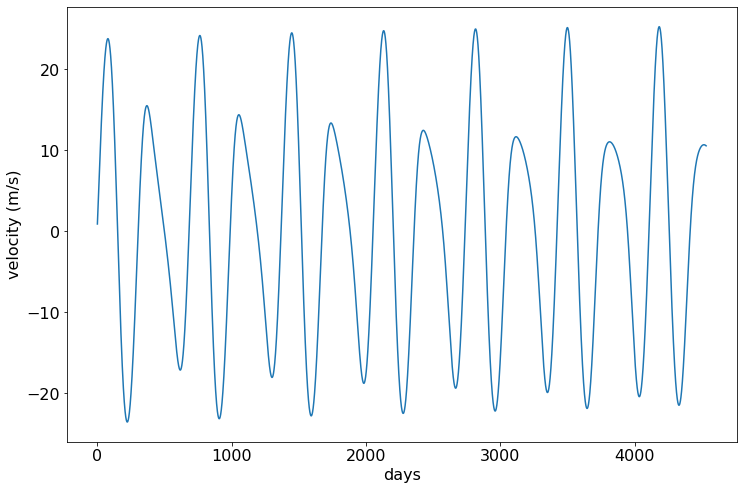

In [415]:
plt.figure(figsize = (12, 8))
plt.plot(times, Ks_sim_rvs)
plt.xlabel('days'), plt.ylabel('velocity (m/s)')
# plt.plot(Ks_sim_times, rb_rv_signal)

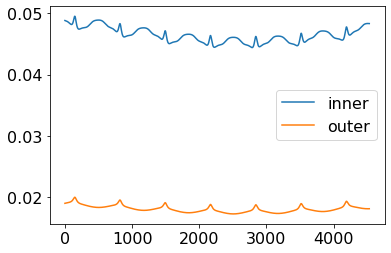

In [416]:
plt.plot(times, e1s, label = 'inner')
plt.plot(times, e2s, label = 'outer')
plt.legend()

Now fitting the `Ks_sim_rvs` signal with the forward model:

In [417]:
def get_forward_model_resids(times, params, obs_data, time_base, yerr=1, c=c):
    """
    Gets the normalized residuals for the forward model fit with the radvel function rather than rebound
    
    array: times: times corresponding to the observed RV data (should be the same length as obs_data)
    list or array: params: parameters for the forward model, in the order: 
        [K1, m2/m1, e1, omega1, omegadot, P1, Tp1, rv_offset] as in the get_rv_equilibrium() function
        k1: semi-amplitude of the inner planet, in m/s
        m2/m1: ratio of outer planet to inner planet's mass, dimensionless
        e1: eccentricity of inner planet, dimensionless
        omega1: argument of pericenter of inner planet, radians
        omegadot: rate of precession (omegadot = omegadot_1 = omegadot_2), UNITS
        p1: period of inner planet, days
        tp1: time of pericenter passage of inner planet
        rv_offset: rv offset of star, in m/s
    array: obs_data: observed rv data to fit the forward model rv signal to
    float: time_base: time base for the simulation to start at
    default array: yerr: array of errors in the observed data (by default 1) for normalization, should be same length as obs_data as well
    default float: c: constant c for the conversion from e1/e2 to m2/m1
    """
    obs_y = obs_data
    synth_y, _, _ = get_rv_signal_equilibrium(times, params, c, time_base = time_base)  # equilibrium keplerian model rvs are synthetic y
    obs_yerr = 1  # normalized to 1, since there is no error bars on our rv signal
    # return normalized residuals
    # print(obs_y, synth_y)
    return (obs_y - synth_y) / obs_yerr

Test computing the residuals, making sure to scale the times by the period in days

In [418]:
# compute residuals
test_resids = get_forward_model_resids(times, eq_model_params, Ks_sim_rvs, time_base)
test_resids, times

(array([24.4877528 , 24.64771336, 24.8059329 , ...,  8.99812817,
         8.79791246,  8.59728815]),
 array([0.00000000e+00, 4.53210750e-01, 9.06421500e-01, ...,
        4.53074787e+03, 4.53120108e+03, 4.53165429e+03]))

In [419]:
eq_model_params, rebound_params, radvel.orbit.timeperi_to_timetrans(tp=eq_model_params[-2], per=eq_model_params[-3], ecc=eq_model_params[2], omega=eq_model_params[3])

([7.302610620825898, 2.8116054481001687, 0.048803346188407044, 1.7438988697165
136, 0, 226.58271441090963, -70.98682761332596, 0], [226.58271441090963, 7.302
610620825898, -76.64414336966614, -0.0380502202840619, 0.2176132508022924, 339
.87407161636446, 17.917391189228372, -80.65634423260508, 0.021937548726298724,
 -0.12546317097047668, 0], -76.64414336966614)

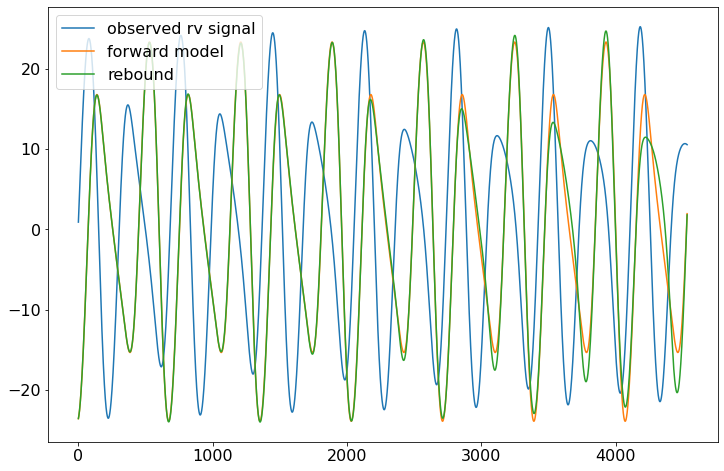

In [420]:
plt.figure(figsize = (12, 8))
# rv signal fit starting from the equilibrium eccentricity track simple sim
plt.plot(times, Ks_sim_rvs, label  = 'observed rv signal') 
# keplerian rvs and rebound rvs for the forward model using the eq_model_params
eq_model_rvs, rebound_rvs, rebound_params = get_rv_signal_equilibrium(times, eq_model_params, c, time_base)

plt.plot(times, eq_model_rvs, label = 'forward model')  # synth y
plt.plot(times, rebound_rvs, label = 'rebound')
# plt.plot(Ks_sim_times, test_resids)
plt.legend()

Now fit to the forward model:

In [89]:
from scipy import optimize
# optimize
fit_params_forward = optimize.least_squares(lambda params: get_forward_model_resids(times, params, Ks_sim_rvs, time_base), eq_model_params)
# takes a long time to fit

Compare fit parameters to the original guess, params are in the order k1, m2/m1, e1, omega1, omegadot, p1, tp1, rv offset

In [90]:
print(f'Least squares fit: \n{fit_params_forward.x}', '\n\n', f'Original guess: \n {eq_model_params}')

Least squares fit: 
[ 7.33996847e+00  2.80666441e+00  4.12923157e-02  7.76355098e+00
 -1.01134989e-04  2.27201128e+02  5.45983166e+04 -3.63590783e-03] 

 Original guess: 
 [7.277435079999999, 2.811620977918289, 0.033899111948287694, 3.397728379422493, 0, 228.51305300000024, 54458.258433793715, -0.529039776]


In [91]:
np.sqrt(np.linalg.inv((fit_params_forward.jac.T @ fit_params_forward.jac))[4][4])

1.1752139249638791e-06

And compare the forward model/rebound simulation using the best-fit parameters to the "observed" data from the rv signal generated from the eccentricity track simple sim at equilibirum, all on the same graph:

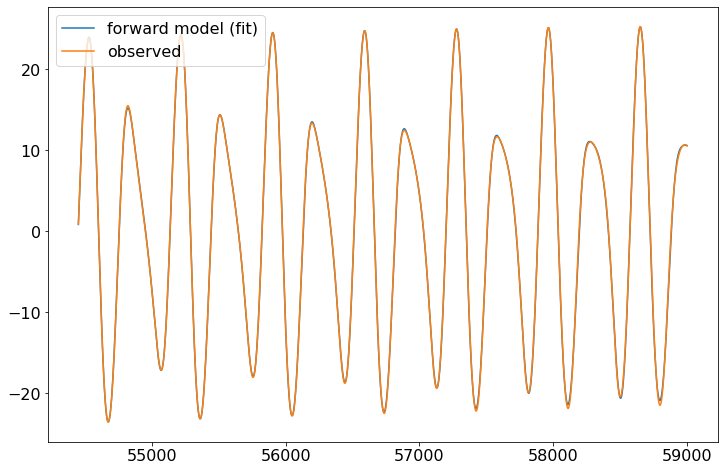

In [92]:
# compute rv signals
fit_eq_rvs, fit_rebound_rvs, _ = get_rv_signal_equilibrium(times, fit_params_forward.x, c, time_base)
eq_model_rvs, rebound_rvs, _ = get_rv_signal_equilibrium(times, eq_model_params, c, time_base)
# in our model we are fitting fit_eq_rvs using the forward model, to the Ks_sim_rvs generated using rebound from the equilibrium eccentricity simulations

# Plot:
plt.figure(figsize = (12, 8))
# forward model and rebound for original guess:
# plt.plot(times, eq_model_rvs, label = 'forward model (original)')
# plt.plot(times, rebound_rvs, label = 'rebound (original)')
# forward model and rebound for fit params:
plt.plot(times, fit_eq_rvs, label = 'forward model (fit)')
# plt.plot(times, fit_rebound_rvs, label = 'rebound (fit)')
# "observed" values, rv signal generated for equilibrium
plt.plot(times, Ks_sim_rvs, label = 'observed')
plt.legend()
plt.show()

In [93]:
fit_eq_rvs, Ks_sim_rvs

(array([ 0.8534697 ,  1.04886564,  1.24452186, ..., 10.59188097,
        10.58729795, 10.5825281 ]),
 array([ 0.90530538,  1.10279053,  1.30053   , ..., 10.56814906,
        10.5611457 , 10.55394579]))

Compare omegadot for the one-planet case (just use the params from `eq_model_params`):

In [94]:
eq_model_params, fit_params_forward.x  # k1, m2/m1, e1, omega1, omegadot, p1, tp1, rv offset

([7.277435079999999,
  2.811620977918289,
  0.033899111948287694,
  3.397728379422493,
  0,
  228.51305300000024,
  54458.258433793715,
  -0.529039776],
 array([ 7.33996847e+00,  2.80666441e+00,  4.12923157e-02,  7.76355098e+00,
        -1.01134989e-04,  2.27201128e+02,  5.45983166e+04, -3.63590783e-03]))

In [53]:
times[-1] - times[0]

4545.668211267162

In [54]:
time_base = np.median(hd_data.BJD)

times = np.linspace(time_base, time_base + inner.P * P1 * 5, int(1e4))  # short
# times = np.linspace(time_base, time_base + inner.P * P1 * 20, int(1e4)) # long

$\frac{2\pi \left(t - T_p\right)}{P} = \lambda - \omega_0 - \dot\omega t$

$T_p = T_{p0} + \dot{T_p} t$

$\varpi = \omega_o + \dot\omega t$

$\lambda = \lambda_0 + 2\pi\frac{t}{P}$


$\dot{T_p} = \frac{P}{2\pi t}\left(-\lambda_0 + \omega_0 + \dot\omega t\right) - \frac{T_{p0}}{t}$

$\dot{T_p} = \frac{P \dot\omega}{2\pi}$

In [58]:
K, _, e, omega0, omegadot, p, tp0, rv_offset = fit_params_forward.x
m1 = m1

# omegadot = 0.01
# compute tpdot from omegadot
# tpdot = -(p * omegadot_fit_params.x[0])/(2 * np.pi)

# now rebound/reboundx simulation with p, tp, e, omega, K and omegadot as well

# parameterize things for get_sim_from_params
tc = radvel.orbit.timeperi_to_timetrans(tp=tp0, per=p, ecc=e, omega=omega0)
secos, sesin = np.sqrt(e) * np.array([np.cos(omega0), np.sin(omega0)])

# parameterize
reboundx_params = [p, K, tc, secos, sesin, rv_offset]

# create sim
# use whfast since we need whfast to work properly
reboundx_sim = get_sim_from_params(reboundx_params, inclination=np.pi/2, integrator='whfast', time_base=time_base)
# define star, planet
star = reboundx_sim.particles[0]
planet = reboundx_sim.particles[1]  # only one planet

# add reboundx
rebx = reboundx.Extras(reboundx_sim)
rebx.add_operator(rebx.load_operator('modify_orbits_direct'))
# add omegadot precession rate
planet.params['tau_omega'] = (2 * np.pi) * 1/omegadot

# create empty arrays
reboundx_rvs = np.zeros(len(times))
reboundx_tps = np.zeros(len(times))
reboundx_omegas = np.zeros(len(times))

one_planet_precess_rv_drive = np.zeros(len(times))

# integrate
for i, t in enumerate(times):
    reboundx_sim.integrate(t)
    reboundx_rvs[i] = (-star.vz * AUDAY_MS)  # no rv offset for these simple sims
    
    reboundx_tps[i] = planet.T
    reboundx_omegas[i] = planet.omega
    period, Tp, e, omega = planet.P, planet.T, planet.e, planet.omega
    one_planet_precess_rv_drive[i] = radvel.kepler.rv_drive(np.array([t]), [period, Tp, e, omega, K])

# radvel for p, tp, e, omega, K
# print(p, tp, time_base, tpdot, e, omega, K)
one_planet_precess_rvs_keplerian_tps = np.array([radvel.kepler.rv_drive(np.array([t]), [p, tp0, e, omega0 + (t - time_base) * omegadot, K]) for t in times])
# want the above one to fit
one_planet_precess_rvs_rebound_tps = np.array([radvel.kepler.rv_drive(np.array([t]), [p, Tp, e, omega0 + (t - time_base) * omegadot, K]) for t, Tp in zip(times, reboundx_tps)])
one_planet_no_precess_rvs = np.array([radvel.kepler.rv_drive(np.array([t]), [p, tp0, e, omega0, K]) for t in times])
# fitting
# omegadot_fit_params = optimize.least_squares(lambda params: get_resids_linear_fit(params, np.unwrap(reboundx_omegas), times), [omegadot, omega0])

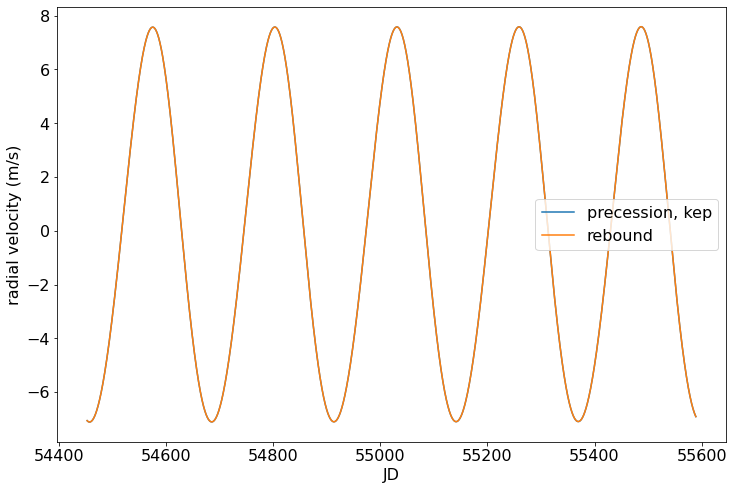

In [60]:
# plot
plt.figure(figsize = (12, 8))
# keplerian with/without precession
# plt.plot(times, one_planet_no_precess_rvs, label = 'no precession, keplerian')  # no precession
plt.plot(times, one_planet_precess_rvs_keplerian_tps, label = 'precession, kep')  # precession by feeding in kepler tps into rv drive
# plt.plot(times, one_planet_precess_rvs_rebound_tps, label = 'precession, rebound (tp omega)')
# plt.plot(times, one_planet_precess_rv_drive, label = 'precession, rebound (all params)')  # precession by feeding in rebound tps into rv drive
# rebound with reboundx precession model
plt.plot(times, reboundx_rvs, label = 'rebound')  # rebound w/ reboundx and precession
plt.xlabel('JD'), plt.ylabel('radial velocity (m/s)')
plt.legend()
plt.show()

Now generate new signals from the equilibrium values of the eccentricity simulations, and then use those. First test with one specific simulation:

In [124]:
ggsim = rb.Simulation(f'hd_max_mass/ecc_track_archive_cluster_{index}.bin')
# check starting inner, outer eccentricities and omegas
ggsim.particles[1].e, ggsim.particles[2].e, ggsim.particles[1].omega, ggsim.particles[2].omega  

(0.04880334618840714, 0.019049458693174662, 1.7438988697165119, 4.850666461103
929)

In [218]:
index = np.abs(Ks_orig - 90).argmin()  # index of the Ks_original closest to K = 90
Ks_orig[index]

ecc_sims_location = 'hd_max_mass'  # location of simulations
# get the simulation
Ks_sim = rb.Simulation(f'{ecc_sims_location}/ecc_track_archive_cluster_{index}.bin')  # get the corresponding eccentricity simulation
# define star, inner, outer planets
star = Ks_sim.particles[0]
inner = Ks_sim.particles[1]
outer = Ks_sim.particles[2]
# use whfast instead of ias15 for the integrator since reboundx omegadot implementation breaks with ias15
Ks_sim.integrator = 'whfast'  # use whfast
Ks_sim.dt = inner.P * 1/50  # 1/50th the period of the inner planet

Ks_sim.t = time_base  # set Ks_sim time base to time base
# since it's already at equilibrium, then make an RV signal with REBOUND over a few orbital periods
# 10 times the orbital period of the inner planet

# define rotation matrix
r = np.matrix([[1, 0, 0],
              [0, 0, 1],
              [0, 1, 0]])  # np.pi/2 rotation matrix so everything is aligned along z

# move to center of mass and then align it so z-axis is movement
# rotate simulation so z axis is aligned, and then move to center of mass
rotate_sim(Ks_sim, r)
Ks_sim.move_to_com()

# add reboundx
# rebx = reboundx.Extras(Ks_sim)
# rebx.add_operator(rebx.load_operator('modify_orbits_direct'))
# # define omegadot precession rate
# omegadot = 1e-16  # try really small since the eq_model_params should be 0
# # then add tau omegas
# inner.params['tau_omega'] = (2 * np.pi) * 1/omegadot
# outer.params['tau_omega'] = (2 * np.pi) * 1/omegadot

# generate time array and other arrays, then integrate
nperiods = 20  # number of inner planet periods for the integration times of both the "observed" rebound data and the other 2

# now get rvs using rebound
times = np.linspace(Ks_sim.t, Ks_sim.t + inner.P * P1 * nperiods, int(1e4))  # 10 periods
Ks_sim_rvs = np.zeros(len(times))

# define arrays
e1s = np.zeros(len(times))
e2s = np.zeros(len(times))
omega1s = np.zeros(len(times))
omega2s = np.zeros(len(times))

inner = Ks_sim.particles[1]
outer = Ks_sim.particles[2]

# loop
for i, t in enumerate(times):
    # integrate the simple sim
    # have to scale the time by the period as time_base + (t - time_base)/P1 since in "natural" units of P1
    # the range of times is ~19 but in units of BJD times is about ~5000, both starting at the time_base of ~54452
    Ks_sim.integrate(time_base + (t - time_base)/P1, exact_finish_time = 1)
    # compute the rvs, making sure to convert from au/day to m/s again
    # multiply by conversion
    Ks_sim_rvs[i] = (-star.vz * v_conv) # no rv offset for these simple sims
    e1s[i] = inner.e
    e2s[i] = outer.e
    omega1s[i] = inner.omega
    omega2s[i] = outer.omega

In [219]:
np.finfo(float).eps

2.220446049250313e-16

In [220]:
(time_base + (times[-1] - time_base)/P1), (time_base + (times[0] - time_base)/P1)

(54472.58248222553, 54452.75143000018)

Plotting the rvs for the rebound "observed" values against the forward model values using the previous least-squares optimization:

In [221]:
eq_model_ls_params = [ 7.33996847e+00, 2.80666441e+00, 4.12923157e-02, 7.76355098e+00, -1.01134989e-04, 2.27201128e+02, 5.45983166e+04, -3.63590783e-03] 

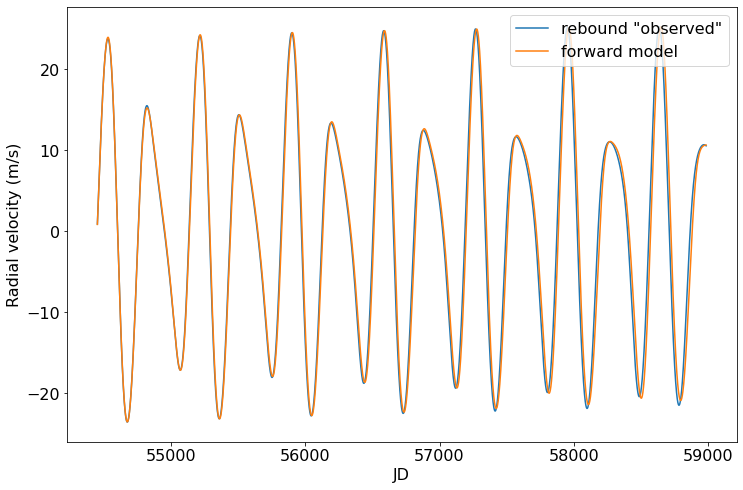

In [222]:
plt.figure(figsize = (12, 8))
# these are the rvs generated using a rebound simulation from the equilibrum eccentricity simulations
plt.plot(times, Ks_sim_rvs, label = 'rebound "observed"')
# compute the equilibrium forward model times using eq_model_params (derived from the original best-fit solution to the observed data) 
c = 1.07  # c is about 1.07, derived (coefficient for e1/e2 = c * m2/m1)
eq_model_rvs, _, _ = get_rv_signal_equilibrium(times, eq_model_ls_params, c, time_base)
# these are the rvs generated using the forward model from eq_model_params derived from the original best-fit solution
plt.plot(times, eq_model_rvs, label = 'forward model')
plt.xlabel('JD'), plt.ylabel('Radial velocity (m/s)')
plt.legend()
plt.show()

Plotting the eccentricities to check as well:

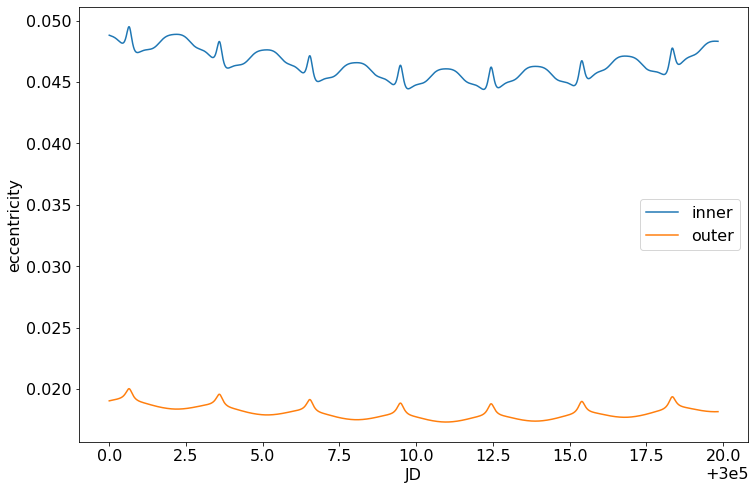

In [223]:
plt.figure(figsize=(12, 8))
plt.plot(times, e1s, label = 'inner')  # inner ecc
plt.plot(times, e2s, label = 'outer')  # outer ecc
plt.xlabel('JD'), plt.ylabel('eccentricity')
plt.legend()
plt.show()

And omegas:

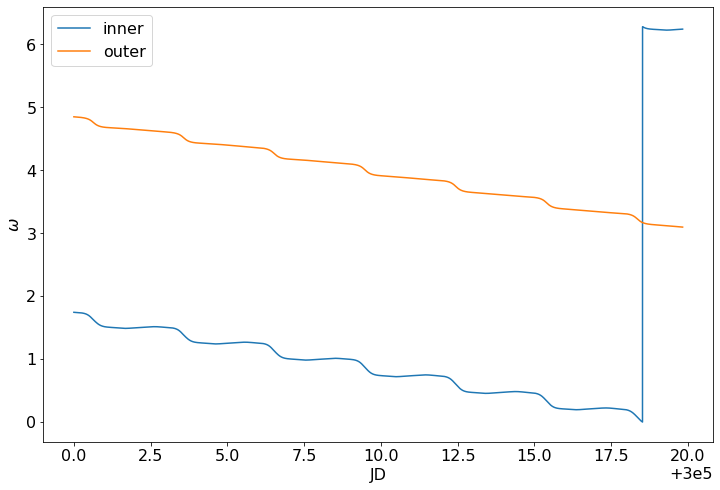

In [224]:
plt.figure(figsize=(12, 8))
plt.plot(times, omega1s, label = 'inner')  # inner omega
plt.plot(times, omega2s, label = 'outer')  # outer omega
plt.xlabel('JD'), plt.ylabel(r'$\omega$')
plt.legend()
plt.show()

Now fit the forward model to the rebound values and compare the second fit with original guess (first fit)
Params are $k_1, \frac{m_2}{m_1}, e_1, \omega_1, \dot\omega, P_1, T_{p1}$

In [225]:
fit_params_forward = optimize.least_squares(lambda params: get_forward_model_resids(times, params, Ks_sim_rvs, time_base), eq_model_ls_params)

In [226]:
print(f'Least squares fit: \n{fit_params_forward.x}', '\n\n', 
      f'Original (best-fit from observations) guess: \n {eq_model_params}')



Least squares fit: 
[ 7.33996847e+00  2.80666443e+00  4.12923946e-02  7.76355006e+00
 -1.01447652e-04  2.26500686e+02  5.45978678e+04 -3.63593662e-03] 

 Original (best-fit from observations) guess: 
 [7.277435079999999, 2.811620977918289, 0.033899111948287694, 3.397728379422493, 0, 228.51305300000024, 54458.258433793715, -0.529039776]


And compare the fit to see if the parameters are recovered:

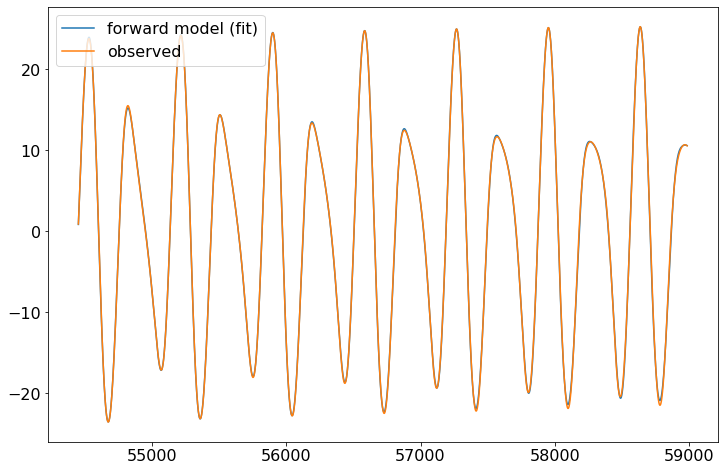

In [215]:
# compute rv signals for both:
fit_eq_rvs, fit_rebound_rvs, _ = get_rv_signal_equilibrium(times, fit_params_forward.x, c, time_base)  # generate forward model rvs using the least-squares optimziation params
eq_model_rvs, rebound_rvs, _ = get_rv_signal_equilibrium(times, eq_model_params, c, time_base)  # gneerate eq_model_rvs using the original best-fit from observations guess
# in our model we are fitting fit_eq_rvs using the forward model, to the Ks_sim_rvs generated using rebound from the equilibrium eccentricity simulations

# Plot the rv signals
plt.figure(figsize = (12, 8))
# forward model and rebound for original guess:
# plt.plot(times, eq_model_rvs, label = 'forward model (original)')
# plt.plot(times, rebound_rvs, label = 'rebound (original)')
# forward model and rebound for fit params:
plt.plot(times, fit_eq_rvs, label = 'forward model (fit)')
# plt.plot(times, fit_rebound_rvs, label = 'rebound (fit)')
# "observed" values, rv signal generated for equilibrium
plt.plot(times, Ks_sim_rvs, label = 'observed')
plt.legend()
plt.show()

Todo: make sure omegadot is the correct value and also implemented properly, and then fit the forward model to the rvs generated above by rebound (also make sure the forward model (esp omegadot) is implemented properly as well...)

In [61]:
nsims = 100
Ks_orig = np.logspace(0, 5, nsims)
ecc_sims_location = 'hd_max_mass'
# initialize c array
cs = np.zeros(len(Ks_orig))

for i in range(0, len(Ks_orig)):
    ecc_sim = rb.Simulation(f'{ecc_sims_location}/ecc_track_archive_cluster_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    inner = ecc_sim.particles[1]
    outer = ecc_sim.particles[2]
    

### unused

In [119]:
# omegadot = 0.001

# test_sim = rb.Simulation()
# test_sim.add(m=1)
# test_sim.add(a=1, e=0.1)

# star = test_sim.particles[0]
# planet = test_sim.particles[1]
# omega0 = planet.omega

# rebx = reboundx.Extras(test_sim)
# rebx.add_operator(rebx.load_operator('modify_orbits_direct'))
# # add omegadot precession rate
# planet.params['tau_omega'] = (2 * np.pi) * 1/omegadot

# test_pomegas = np.zeros(len(times))

# for i, t in enumerate(times):
#     test_sim.integrate(t)
#     test_pomegas[i] = planet.pomega

    
# plt.plot(times, test_pomegas)
# plt.plot(times, np.mod([omega0 + (t - time_base) * omegadot for t in times], 2 * np.pi))
# plt.axvline(planet.params['tau_omega']/(2 * np.pi), color='k')

In [120]:
reboundx_omegas, omega0

(array([0.70431974, 0.70545627, 0.7065928 , ..., 5.7830319 , 5.78416843,
        5.78530496]),
 13.270690352783015)

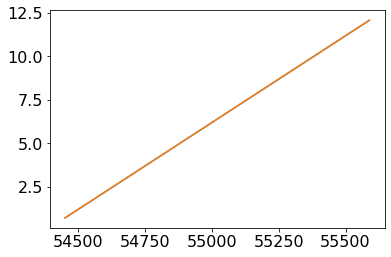

In [122]:
plt.plot(times, np.unwrap(reboundx_omegas))
plt.plot(times, omegadot * (times - time_base) + reboundx_omegas[0])
# plt.plot(times, np.mod([omega0 + (t - time_base) * omegadot for t in times], 2 * np.pi))
# plt.plot(times, [omegadot_fit_params.x[1] + (t - time_base) * omegadot_fit_params.x[0] for t in times])

In [127]:
reboundx_omegas, omegadot * (times - time_base) + reboundx_omegas[0]

(array([0.70431974, 0.70545627, 0.7065928 , ..., 5.7830319 , 5.78416843,
        5.78530496]),
 array([ 0.70431974,  0.70545627,  0.7065928 , ..., 12.06621721,
        12.06735374, 12.06849027]))

In [128]:
np.mod(reboundx_tps, p)

array([70.05034364, 70.05034364, 70.05034364, ..., 70.05034361,
       70.05034361, 70.05034361])

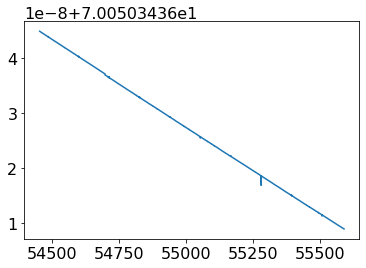

In [129]:
plt.plot(times, np.mod(reboundx_tps, p))

In [57]:
def get_resids_linear_fit(params, y, x):
    """
    linear fit for y = ax + b    
    params: a, b in that order
    """
    a, b = params
    obs_y = y
    synth_y = a * x + b
    return np.abs(obs_y - synth_y)
    

In [84]:
# omegadot_fit_params = optimize.least_squares(lambda params: get_resids_linear_fit(params, np.unwrap(reboundx_omegas), times), [omegadot, omega0])

In [85]:
omegadot, omegadot_fit_params.x

(0.01, array([ 3.95600777e-02, -2.15342000e+03]))

In [ ]:
omega0


In [ ]:
time_base

In [ ]:
-1/omegadot

In [ ]:
np.reshape(one_planet_no_precess_rvs, -1), reboundx_rvs

In [ ]:
p, 1/omegadot

In [ ]:
times, time_base